In [659]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import scipy.stats as stats
from IPython.display import display, Math,  Latex
matplotlib.style.use('ggplot')
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

%matplotlib inline  

/opt/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [660]:
from sklearn.naive_bayes import GaussianNB
from sklearn import cross_validation
from sklearn import metrics
from tqdm import *

def classifier_crossval_perormance(x, Y, classifier=GaussianNB(), n_folds=10, weights=None, bins=50):
    #print some empty lines
    print("\n \n")
    
    #create axis and figure
    fig,(ax, ax2, ax3) = plt.subplots(3 , 1)
    fig.set_size_inches(12, 18)
    #create inset axis for zooming
    axins = zoomed_inset_axes(ax, 3.5, loc=1)
    
    labels_predctions = []


    #save all aucs and confusion matrices for each cv fold
    roc_aucs = []
    confusion_matrices = []
    precisions = []
    recalls = []
    f_scores = []

    #iterate over test and training sets 
    cv = cross_validation.StratifiedKFold(y, n_folds=n_folds)
    test_weights = None
    
    for train, test in tqdm(cv):
        #select data
        xtrain, xtest = x[train], x[test]
        ytrain, ytest = Y[train], Y[test]
        
        #fit and predict 
        classifier.fit(xtrain, ytrain)
        y_probas = classifier.predict_proba(xtest)[:,1]
        y_prediction = classifier.predict(xtest)
        labels_predctions.append((ytest, y_prediction, y_probas))
    
    #calculate metrics
    #save all aucs and confusion matrices for each cv fold
    roc_aucs = np.zeros(n_folds)
    confusion_matrices = np.zeros([n_folds,2,2])
    precisions = np.zeros(n_folds)
    recalls = np.zeros(n_folds)
    f_scores = np.zeros(n_folds)

    for i, (test, prediction, proba) in enumerate(labels_predctions):
        matrix = metrics.confusion_matrix(test, prediction)
        p,r,f,_ = metrics.precision_recall_fscore_support(test, prediction, sample_weight=test_weights)
        auc = metrics.roc_auc_score(test, proba, sample_weight=test_weights)
        
        confusion_matrices[i] = matrix
        roc_aucs[i] = auc
        precisions[i] = p[1]
        recalls[i] = r[1]
        f_scores[i] = f[1]

        
    #plot roc aucs 
    for test, prediction, proba in labels_predctions:
        fpr, tpr, thresholds = metrics.roc_curve(test, proba, sample_weight=test_weights)
        ax.plot(fpr, tpr, linestyle="-", color="0.4")
        axins.plot(fpr, tpr, linestyle="-", color="0.4")

    #plot stuff with confidence cuts
    matrices = np.zeros((n_folds, bins, 2, 2))
    for fold, (test, prediction, probas) in enumerate(labels_predctions):    
        for i, cut in enumerate(np.linspace(0,1,bins)):
            cutted_prediction = prediction.copy()
            cutted_prediction[probas < cut] = 0
            cutted_prediction[probas >= cut] = 1
            confusion = metrics.confusion_matrix(test, cutted_prediction)
            matrices[fold][i] = confusion         

    
    b = np.linspace(0,1,bins)
    
    tps = matrices[:,:,0, 0]
    fns = matrices[:,:,0, 1]
    fps = matrices[:,:,1, 0]
    tns = matrices[:,:,1, 1]

    q_mean = np.mean(tps / np.sqrt(tns), axis=0)
    q_err = np.std(tps / np.sqrt(tns), axis=0)
    e_mean = np.mean(tps / np.sqrt(tns + tps), axis=0)
    e_err = np.std(tps / np.sqrt(tns + tps), axis=0)
    
    ax2.plot(b, q_mean , color="blue", linestyle="", marker="+", label=r"$\frac{tps}{\sqrt{tns}}$")
    ax2.plot(b, e_mean , color="#58BADB", linestyle="", marker="+", label=r"$\frac{tps}{\sqrt{tns + tps}}$")
    ax2.fill_between(b, q_mean + q_err*0.5, q_mean - q_err*0.5, facecolor='gray', alpha=0.4)
    ax2.fill_between(b, e_mean + e_err*0.5, e_mean - e_err*0.5, facecolor='gray', alpha=0.4)
    ax2.legend(loc='best', fancybox=True, framealpha=0.5)
    ax2.set_xlabel("prediction threshold")
    
    accs = (tps + tns)/(tps + fps + fns + tns)
    acc_mean = np.mean(accs, axis=0)
    acc_err = np.std(accs, axis=0)
    
    ax3.plot(b, acc_mean , color="red", linestyle="", marker="+", label=r"Accuracy")
    ax3.fill_between(b, acc_mean + acc_err*0.5, acc_mean - acc_err*0.5, facecolor='gray', alpha=0.4)
    ax3.legend(loc='best', fancybox=True, framealpha=0.5)
    ax3.set_xlabel("prediction threshold")
   

    ax.set_xlabel("False Positiv Rate")
    ax.set_ylabel("True Positiv Rate")
    ax.set_ylim(0.0,1.0)
    ax.set_xlim(0, 1.0)
    axins.set_xlim(0, 0.15)
    axins.set_ylim(0.8, 1.0)
    axins.set_xticks([0.0, 0.05, 0.1, 0.15])
    axins.set_yticks([0.8, 0.85, 0.9, 0.95, 1.0])
    mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.8")
    name = str(type(classifier).__name__)
    ax.set_title("RoC curves for the {} classifier".format(name), y=1.03)
    
    print_performance(roc_aucs ,confusion_matrices,precisions,recalls, f_scores)
    plt.show()
    return roc_aucs

In [661]:


def print_performance(roc_aucs ,confusion_matrices,precisions,recalls, f_scores):

    tp = confusion_matrices[:, 0 , 0]
    fn = confusion_matrices[:, 0 , 1]
    fp = confusion_matrices[:, 1 , 0]
    tn = confusion_matrices[:, 1 , 1]
    
    
    l = r"""\begin{matrix}
      {:.2f} \pm {:.2f} & {:.2f} \pm {:.2f} \\
      {:.2f} \pm {:.2f} & {:.2f} \pm {:.2f} 
     \end{matrix}""".format(tp.mean(),tp.std(), fn.mean(),fn.std(),fp.mean(),fp.std(), tn.mean(), tn.std(), matrix="{matrix}")

    print("Confusion matrix: ")
    display(Latex(l))
    print()
    
    fpr = fp/(fp + tn)
    relative_error = (fpr.std() / fpr.mean() )*100
    print("Mean False Positive Rate:: ")
    l = r"""{:.5f} \pm {:.5f}  \qquad (\pm {:.1f} \quad \%)""".format(fpr.mean(), fpr.std(), relative_error)

    display(Math(l))
    print()
    

    print("Mean area under ROC curve: ")
    relative_error = (roc_aucs.std() / roc_aucs.mean() )*100
    l = r"""{:.5f} \pm {:.5f} \qquad (\pm {:.1f} \quad \%)""".format(roc_aucs.mean(), roc_aucs.std(), relative_error)
    display(Math(l))
    print()
    
    #print("Mean precission:")
    #p_mean = perf_dict["precision"].mean()
    #p_error = perf_dict["precision"].std()/np.sqrt(len(perf_dict["precision"]))
    #l = r"""{:.5f} \pm {:.5f}""".format(p_mean, p_error)
    #display(Math(l))
    #print()
    
    
    print("Mean recall:")
    relative_error = (recalls.std() / recalls.mean() )*100
    l = r"""{:.5f} \pm {:.5f}\qquad (\pm {:.1f} \quad \%)""".format(recalls.mean(), recalls.std(), relative_error)
    display(Math(l))
    print()
    
    print("Mean fscore:")
    relative_error = (f_scores.std() / f_scores.mean() )*100
    l = r"""{:.5f} \pm {:.5f}\qquad (\pm {:.1f} \quad \%)""".format(f_scores.mean(), f_scores.std(), relative_error)
    display(Math(l))
    print()

In [662]:
from sklearn import cross_validation
from sklearn import metrics
from sklearn import calibration

def plot_recall_precission_curve(y, y_prediction, weights =  None, bins=50):
    precision, recall, thresholds = metrics.precision_recall_curve(y, y_prediction, sample_weight=weights)
    #print(metrics.accuracy_score(y_test, gnb.predict(X_test)))
    
    fraction_of_positives, mean_predicted_value = calibration.calibration_curve(y, y_prediction, n_bins=bins)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(13,5))
    ax1.hist(y_prediction, bins=bins)
    ax1.set_title("Histogram of predicted probabilities")
    ax1.set_xlabel("Probabilities")
    #print(precision, recall)
    
    
    ax2.plot(recall, precision, label="Recall /TPR", linestyle="-")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    #ax.plot(thresholds, precision[:-1], label="Precision")
    #ax2.legend()
    ax2.set_title("Precision/Recall curve")
    
    ax3.plot(mean_predicted_value, fraction_of_positives)
    ax3.plot([0,1], [0,1], color="gray", linestyle="--")
    ax3.set_xlabel("Mean Predicted Value")
    ax3.set_ylabel("Fraction of positives")
    
    plt.tight_layout()
    plt.show()

In [663]:
#load signal 
df_signal = pd.read_csv("signal.csv", sep=";")
df_signal.dropna(axis=[1,0], how='all', inplace=True)
print("Number of signal Features: {}. Label {}".format(len(df_signal.columns), df_signal.label.iloc[0]))

#load background
df_background = pd.read_csv("background.csv", sep=";")
df_background.dropna(axis=[1,0], how='all', inplace=True)
print("Number of background features: {}. Label: {}".format(len(df_background.columns), df_background.label.iloc[0]))

#lets only take columns that appear in both datasets
df = pd.concat([df_signal, df_background], axis=0, join='inner')

#match  all columns containing the name 'corsika'
c = df.filter(regex="((C|c)orsika)(\w*[\._\-]\w*)?").columns
df = df.drop(c, axis=1)

#match any column containing header, MC, utc, mjd, date or ID. Im sure there are better regexes for this.
c = df.filter(regex="\w*[\.\-_]*(((u|U)(t|T)(c|C))|(MC)|((m|M)(j|J)(d|D))|(Weight)|((h|H)eader)|((d|D)ate)|(ID))+\w*[\.\-_]*\w*").columns
df = df.drop(c, axis=1)

#drop columns containing only a single value
df = df.drop(df.var()[df.var() == 0].index, axis=1)
#some features are weird. Pearsons r is NaN. Better drop those columns
#corr = df.apply(lambda c: stats.pearsonr(c, df.label)[0])
#df = df.drop(corr[corr.isnull()].index, axis=1)
#print(df.columns)
print("Combined Features: {}".format(len(df.columns)))

#df.describe()


Number of signal Features: 264. Label 1.0
Number of background features: 224. Label: 0.0
Combined Features: 150


#### Data weights and Signal/Background ratio

Each data sample comes with a weight. Usually IceCube MonteCarlos are simulated with a $E^{-1}$ spectrum. At first we sum up all the weights for each class and divide them to get the ratio. 

In [664]:
signal_weight = df_signal["Weight.HoSa"].sum()
background_weight = df_background["Weight.HoSa"].sum()
print("Signal Weight: ")
print(signal_weight)

print("Background Weight: ")
print(background_weight)

print("Ratio:")
ratio = background_weight/signal_weight
print(ratio)

Signal Weight: 
133.46512719302785
Background Weight: 
51035.47648426442
Ratio:
382.38810060438385


This seems a little low. Dataset needs to be reweighted. Lets suppose the real ratio should be something like $1 : 10000$. Then we have to multiply the background weights by  $10000 / 382.388$ and create a new array for sample weights. These have to be normalize to the [0,1] range for use with sklearn as far as I understand.

In [665]:
factor = 10000/ ratio
df_background["Weight.HoSa"] *= factor
background_weight = df_background["Weight.HoSa"].sum()
ratio = background_weight/signal_weight

l = Latex("Signal to background ratio: $1 : {}$".format(ratio))
display(l)

#normalize
sample_weights = np.append(df_background["Weight.HoSa"].values, df_signal["Weight.HoSa"].values)
sample_weights /= np.abs(sample_weights.max() - sample_weights.min())

<IPython.core.display.Latex object>

I haven't quite figured out how to use these weights for evaluating classfiers within sklearn. Feeding these to performance metric functions does nothing. I'm not going to use them further.

#Gaussian Naive Bayes Classifier

Lets try the Gaussian Naive Bayes algorithm first. It assumes that the values of the features are distributed according to a Gaussian. To quote wikipedia:

  > Let $\mu_c$ be the mean of the values in $x$ associated with class $c$, and let $\sigma^2_c$ be the variance of the 
  > values in $x$ associated with class $c$. Then, the probability distribution of some value given a class,
  > $p(x=v|c)$, can be computed by plugging v into the equation for a Normal distribution parameterized by
  > $\mu_c$ and $\sigma^2_c$. That is,
  > $$p(x=v|c)=\frac{1}{\sqrt{2\pi\sigma^2_c}}\,e^{ -\frac{(v-\mu_c)^2}{2\sigma^2_c} } $$
  
Feature scaling or mean shifting is not needed for NaiveBayes. It would have no effect. All NaNs and Infs have to removed however.

In [666]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
df_nb_label = df.dropna(axis=1)["label"]
df_nb = df.dropna(axis=1).drop("label", axis=1)
print("There are {} remaining features after dropping columns containing NaNs.".format(len(df_nb.columns)))

There are 127 remaining features after dropping columns containing NaNs.



 

Confusion matrix: 


<IPython.core.display.Latex object>


Mean False Positive Rate:: 


<IPython.core.display.Math object>


Mean area under ROC curve: 


<IPython.core.display.Math object>


Mean recall:


<IPython.core.display.Math object>


Mean fscore:


<IPython.core.display.Math object>

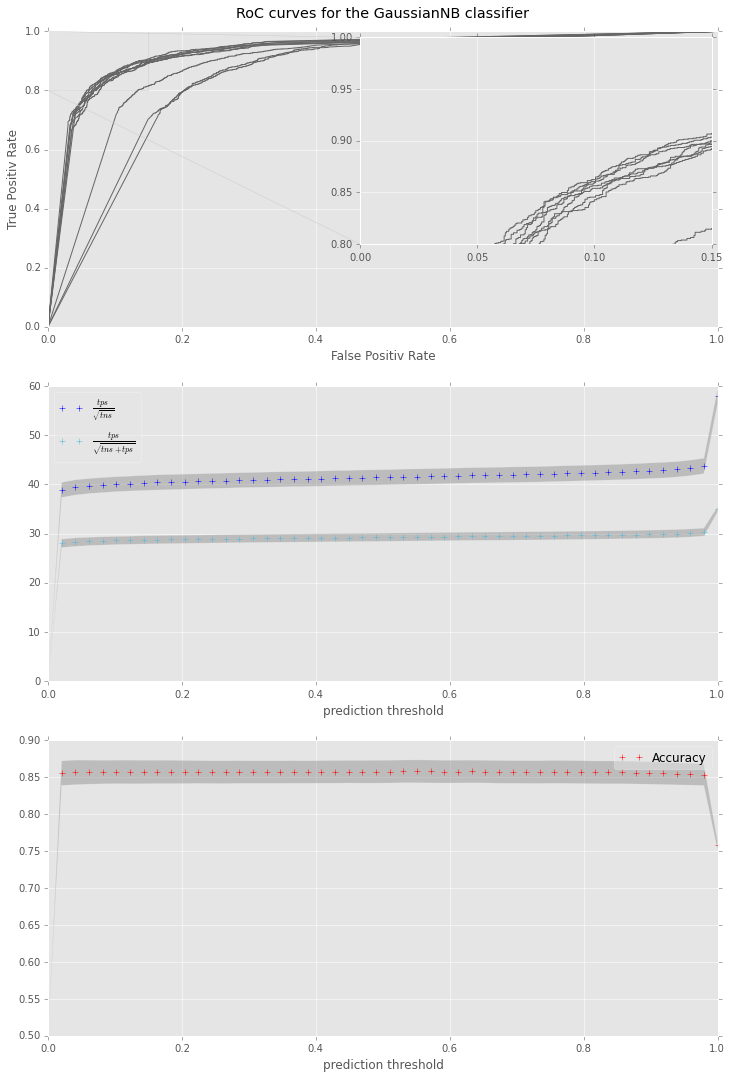

In [667]:
nb_aucs = classifier_crossval_perormance(df_nb.values, df_nb_label.values, classifier=gnb, weights=sample_weights)

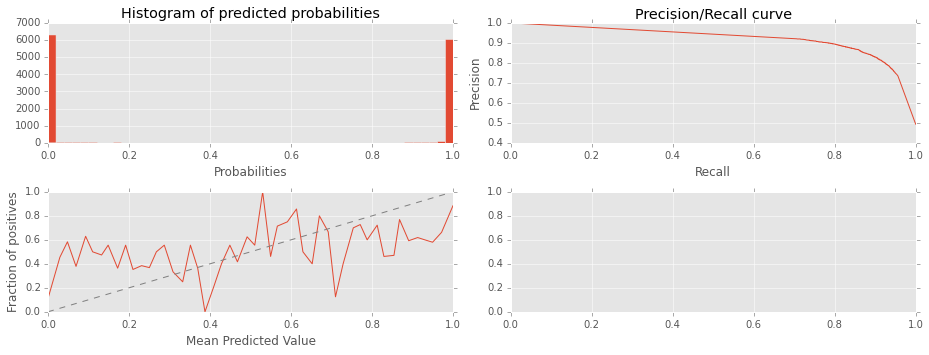

In [668]:
X_train, X_test, y_train, y_test ,_, weights_test= cross_validation.train_test_split(df_nb, df_nb_label, sample_weights, test_size=0.33)

gnb.fit(X_train, y_train)
y_prediction = gnb.predict_proba(X_test)[:,1]

plot_recall_precission_curve(y_test, y_prediction)

#Random Forest Clasifier

The usual ensemble method used by everyone. Scaling is not necessary as we use *Information Gain* to select features in each node.


 

Confusion matrix: 


<IPython.core.display.Latex object>


Mean False Positive Rate:: 


<IPython.core.display.Math object>


Mean area under ROC curve: 


<IPython.core.display.Math object>


Mean recall:


<IPython.core.display.Math object>


Mean fscore:


<IPython.core.display.Math object>

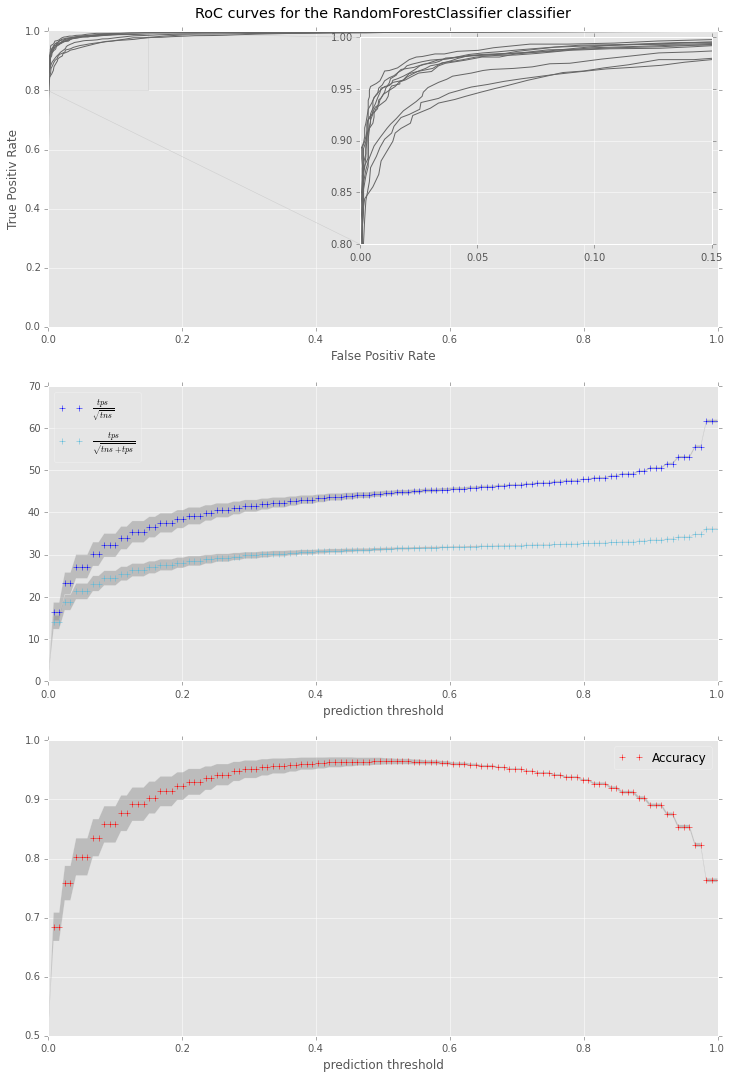

In [669]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_jobs=48, n_estimators=48, criterion="entropy")
X = df.dropna(axis=1).drop("label", axis=1).values
y = df.dropna(axis=1)["label"].values
rf_aucs = classifier_crossval_perormance(X, y, classifier=rf, bins=120)

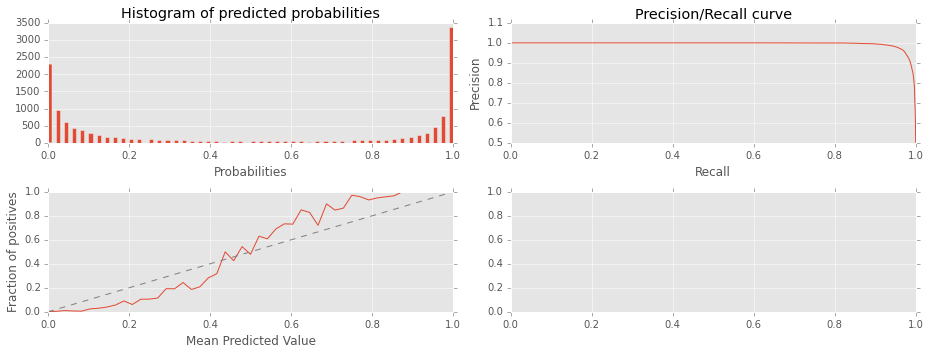

In [671]:
X_train, X_test, y_train, y_test, _, weights_test = cross_validation.train_test_split(X, y, sample_weights, test_size=0.33)

rf.fit(X_train, y_train)
y_prediction = rf.predict_proba(X_test)[:,1]


plot_recall_precission_curve(y_test, y_prediction, weights=None, bins=100)

### Calibration
Calibrate prediction using logistic regression.

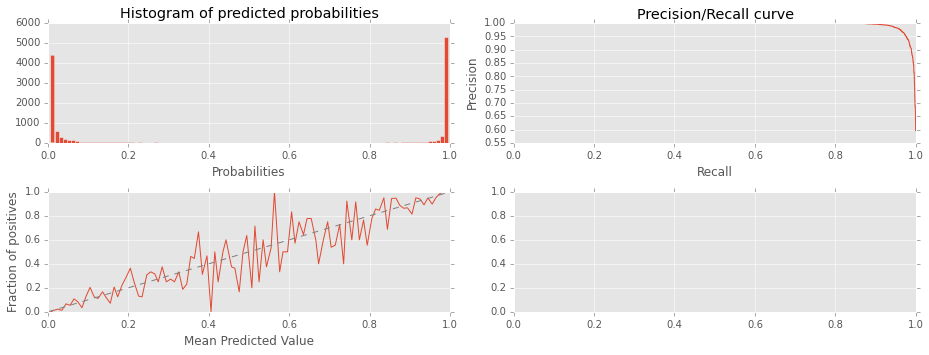

In [672]:
rf_sigmoid = calibration.CalibratedClassifierCV(rf, cv=10, method='sigmoid')
rf_sigmoid.fit(X_train, y_train)
y_prediction = rf_sigmoid.predict_proba(X_test)[:,1]
#print( metrics.roc_auc_score(y_test,y_prediction ))
#print( metrics.roc_auc_score(y_test,y_prediction, sample_weight=weights_test ))

plot_recall_precission_curve(y_test, y_prediction, weights=None, bins=100)

Validate and check the new calibrated classfier. 


 

Confusion matrix: 


<IPython.core.display.Latex object>


Mean False Positive Rate:: 


<IPython.core.display.Math object>


Mean area under ROC curve: 


<IPython.core.display.Math object>


Mean recall:


<IPython.core.display.Math object>


Mean fscore:


<IPython.core.display.Math object>

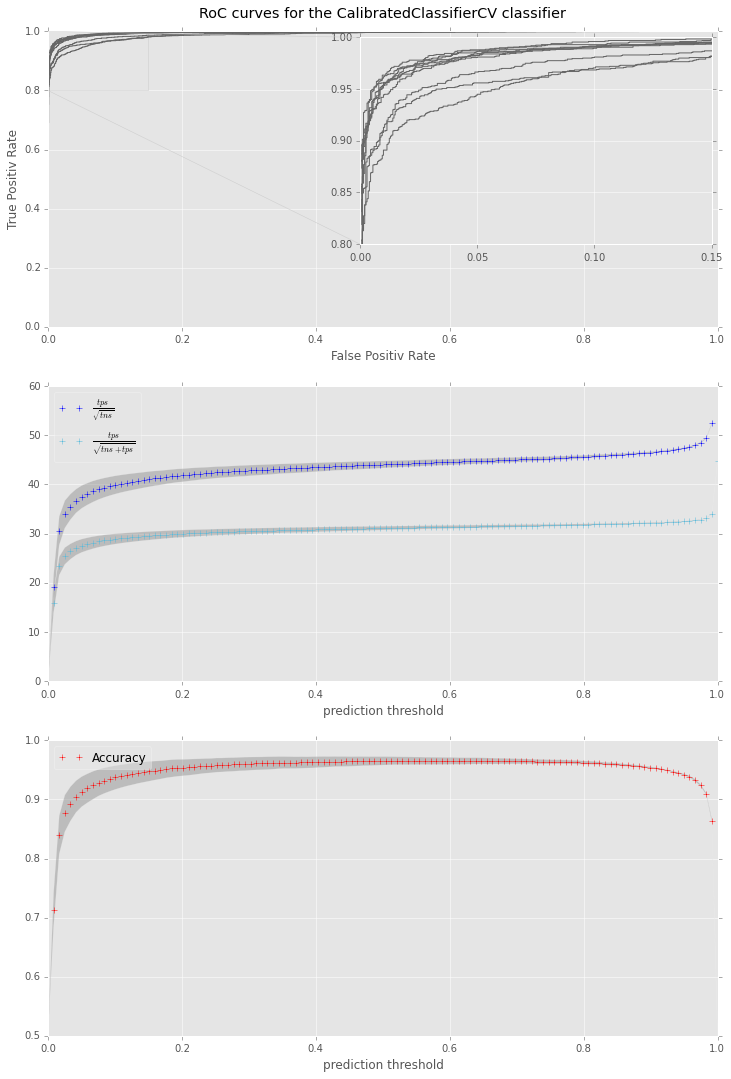

In [673]:
calibrated_rf_aucs = classifier_crossval_perormance(X, y, classifier=rf_sigmoid, bins=120)

Apparently the classification does not get better after calibration.

# Extremly Randomized Trees

This randomizes even more than a random forests. Instead of calculating the best split according to the given criterion, it creates a number of random splits and selects the best of those. In my opinion this should be much faster on continous features. Yay!



 

Confusion matrix: 


<IPython.core.display.Latex object>


Mean False Positive Rate:: 


<IPython.core.display.Math object>


Mean area under ROC curve: 


<IPython.core.display.Math object>


Mean recall:


<IPython.core.display.Math object>


Mean fscore:


<IPython.core.display.Math object>

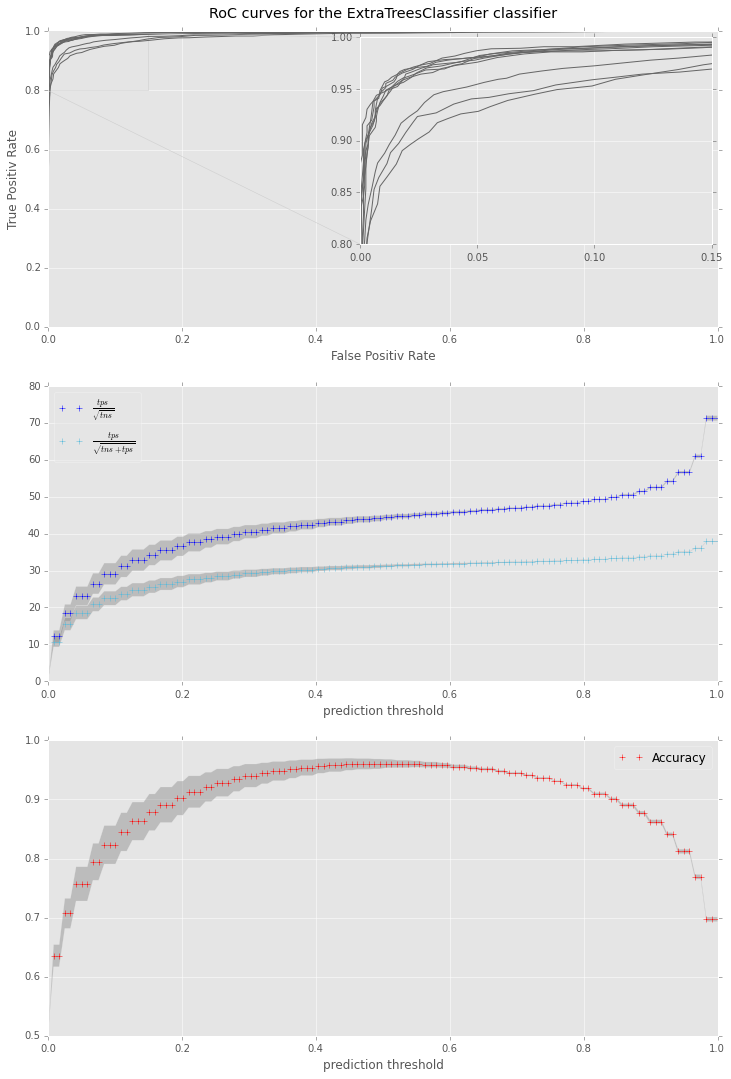

In [678]:
from sklearn import ensemble
extra_rf = ensemble.ExtraTreesClassifier(n_jobs=24, n_estimators=2*24, criterion="entropy")
X = df.dropna(axis=1).drop("label", axis=1).values
y = df.dropna(axis=1)["label"].values
erf_aucs = classifier_crossval_perormance(X, y, classifier=extra_rf, bins=120)

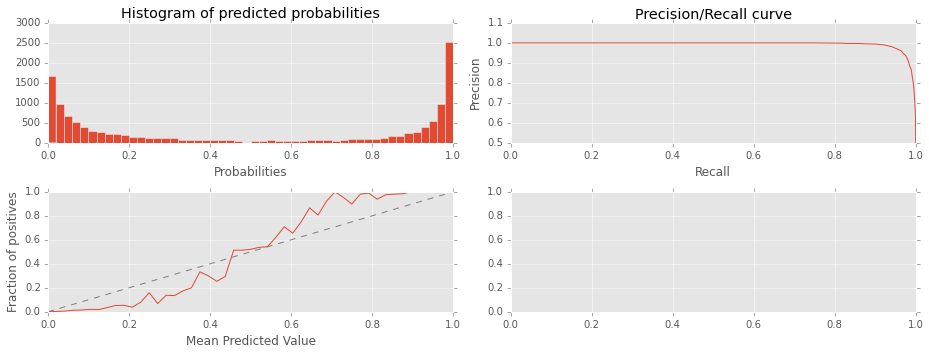

In [679]:
X_train, X_test, y_train, y_test, _, weights_test = cross_validation.train_test_split(X, y, sample_weights, test_size=0.33)
extra_rf.fit(X_train, y_train)

y_prediction = extra_rf.predict_proba(X_test)[:,1]

plot_recall_precission_curve(y_test, y_prediction, weights=None)

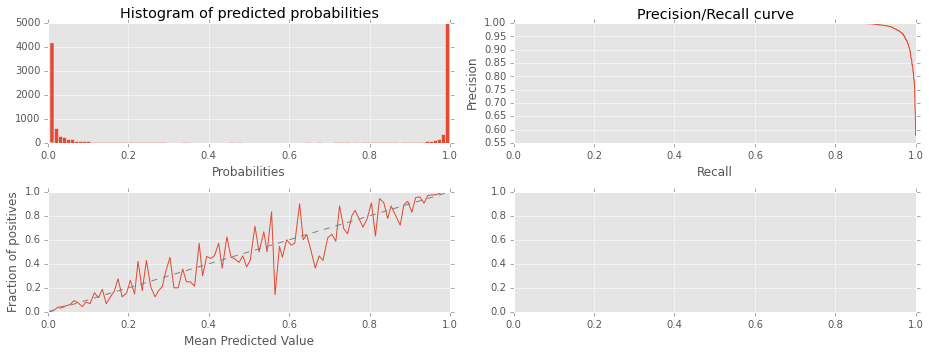

In [680]:
extra_rf_sigmoid = calibration.CalibratedClassifierCV(extra_rf, cv=10, method='sigmoid')
extra_rf_sigmoid.fit(X_train, y_train)
y_prediction = extra_rf_sigmoid.predict_proba(X_test)[:,1]
#print( metrics.roc_auc_score(y_test,y_prediction ))
#print( metrics.roc_auc_score(y_test,y_prediction, sample_weight=weights_test ))

plot_recall_precission_curve(y_test, y_prediction, weights=None, bins=100)

Check calibrated classfier. Takes too long. Im impatient.


 

Confusion matrix: 


<IPython.core.display.Latex object>


Mean False Positive Rate:: 


<IPython.core.display.Math object>


Mean area under ROC curve: 


<IPython.core.display.Math object>


Mean recall:


<IPython.core.display.Math object>


Mean fscore:


<IPython.core.display.Math object>

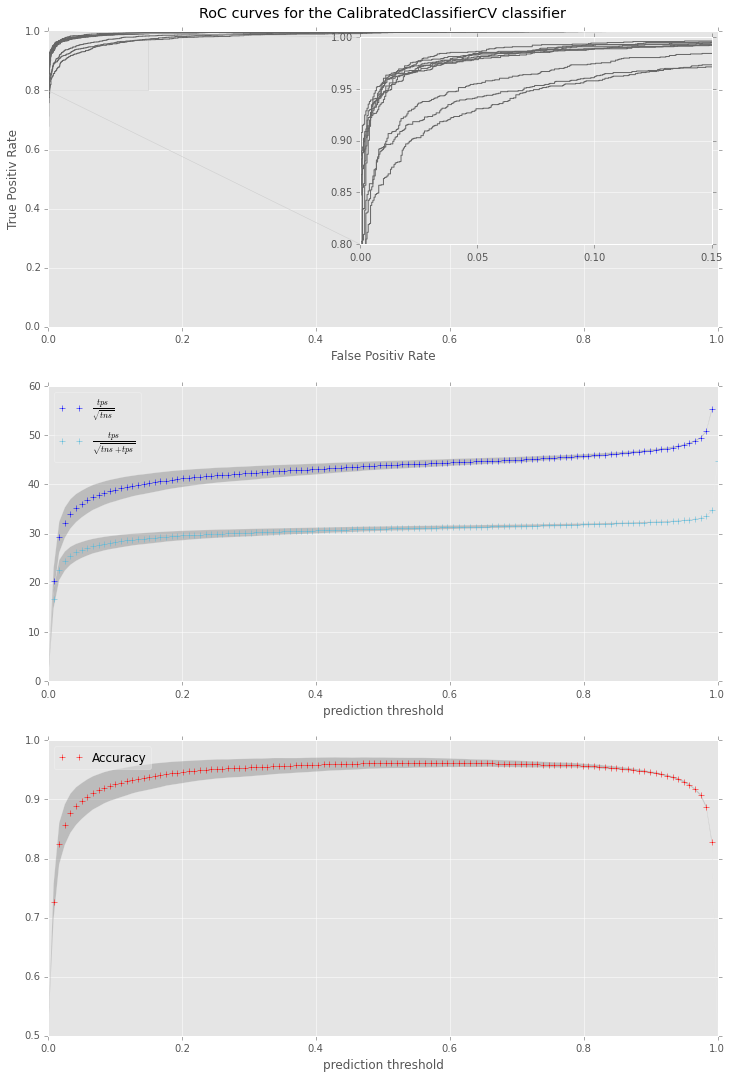

In [681]:
calibrated_erf_aucs = classifier_crossval_perormance(X, y, classifier=extra_rf_sigmoid, bins=120)

#Gradient Boosting Classifier
Use small decission trees (or stumps) in a boosted ensemble.



 

Confusion matrix: 


<IPython.core.display.Latex object>


Mean False Positive Rate:: 


<IPython.core.display.Math object>


Mean area under ROC curve: 


<IPython.core.display.Math object>


Mean recall:


<IPython.core.display.Math object>


Mean fscore:


<IPython.core.display.Math object>

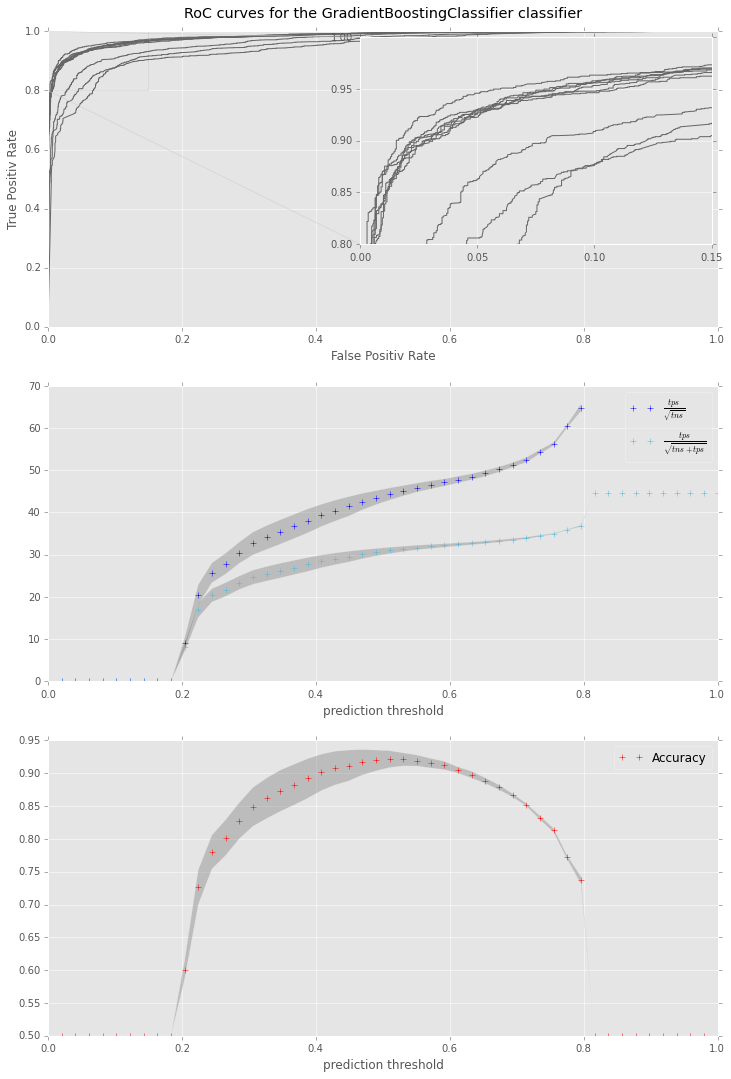

In [684]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = ensemble.GradientBoostingClassifier(n_estimators=10, max_depth=3)
X = df.dropna(axis=1).drop("label", axis=1).values
y = df.dropna(axis=1)["label"].values
grb_aucs  = classifier_crossval_perormance(X, y, classifier=gbc)

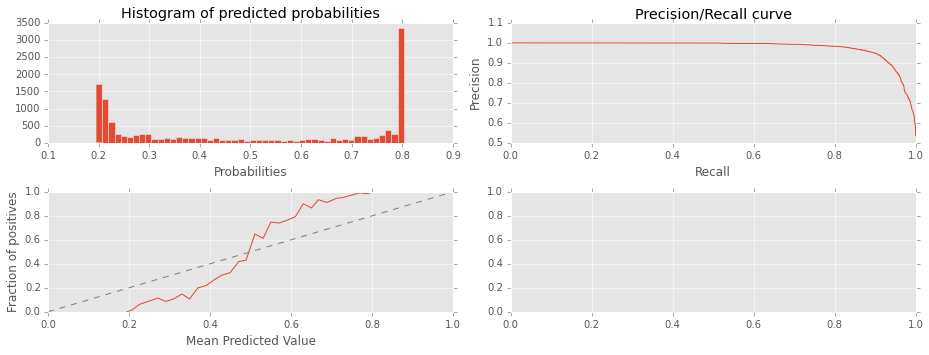

In [685]:
X_train, X_test, y_train, y_test= cross_validation.train_test_split(X, y, test_size=0.33)
gbc.fit(X_train, y_train)

y_prediction = gbc.predict_proba(X_test)[:,1]

plot_recall_precission_curve(y_test, y_prediction)

## Comparing classifier performances

Assuming the values calculated during the cross validation are normaly distributed around a fixed mean we can use a welch test to determine whether the number differ significantly. Here we use Welches t-test for the nullhypothesis of identical sample means with different variances.

In [686]:
from scipy import stats
from itertools import product
def welch_test(a, b, significance = 0.05):
    print(a)
    print(b)
    _, p = stats.ttest_ind(a, b, equal_var = False)
    if p < significance :
        print("Null hypothesis rejected with p: {}. ROC AUC differs significantly".format(p))
    else:
        print("Null hypothesis cannot be rejected with p: {}".format(p))

print("Compare Naive Bayes to Random Forest")
welch_test(nb_aucs, rf_aucs)

print("Compare Random Forest to Extremly Random Forest")
welch_test(rf_aucs, erf_aucs)

print("Compare Extremly Random Forest to Gradient Boosting Classifier")
welch_test(erf_aucs, grb_aucs )

Compare Naive Bayes to Random Forest
[ 0.85385425  0.84763625  0.88638187  0.9374005   0.927169    0.93454287
  0.9323415   0.9324095   0.933466    0.92676125]
[ 0.98905775  0.98835637  0.99120113  0.99643712  0.99645775  0.99584688
  0.99593363  0.99551137  0.99760213  0.99522712]
Null hypothesis rejected with p: 3.538313247991643e-05. ROC AUC differs significantly
Compare Random Forest to Extremly Random Forest
[ 0.98905775  0.98835637  0.99120113  0.99643712  0.99645775  0.99584688
  0.99593363  0.99551137  0.99760213  0.99522712]
[ 0.9857265   0.98456275  0.9896365   0.99607563  0.99652838  0.99566838
  0.99447038  0.99474225  0.9968435   0.995311  ]
Null hypothesis cannot be rejected with p: 0.510435432414863
Compare Extremly Random Forest to Gradient Boosting Classifier
[ 0.9857265   0.98456275  0.9896365   0.99607563  0.99652838  0.99566838
  0.99447038  0.99474225  0.9968435   0.995311  ]
[ 0.94768275  0.94909763  0.96552688  0.98375725  0.98395763  0.98299225
  0.9830715   0.9

##Feature Selection

Use Logistic regression to find good features. This might have an impact on the performance of the NaiveBayes classifier.

In [687]:
import sklearn.feature_selection
from sklearn.linear_model import LogisticRegression

X = df.dropna(axis=1).drop("label", axis=1)
y = df.dropna(axis=1)["label"]

rfe = sklearn.feature_selection.RFE(LogisticRegression() , 10, step = 25)
X_sel = rfe.fit_transform(X, y)

print("Selected features: ")
print(rfe.ranking_)

Selected features: 
[2 2 3 3 4 5 4 3 3 4 2 3 5 5 3 5 5 3 4 1 3 6 6 6 5 4 5 4 4 5 1 4 6 6 4 4 4
 2 4 6 2 4 6 6 6 3 6 6 5 4 3 4 1 3 1 5 5 4 5 1 3 4 1 6 5 6 3 4 2 3 3 4 4 6
 1 2 6 5 4 1 4 3 2 6 5 2 1 5 6 2 2 6 5 2 2 3 1 6 5 2 3 2 3 5 3 6 5 5 3 4 2
 3 6 6 5 5 3 4 2 3 6 5 3 6 6 5 4]



 

Confusion matrix: 


<IPython.core.display.Latex object>


Mean False Positive Rate:: 


<IPython.core.display.Math object>


Mean area under ROC curve: 


<IPython.core.display.Math object>


Mean recall:


<IPython.core.display.Math object>


Mean fscore:


<IPython.core.display.Math object>

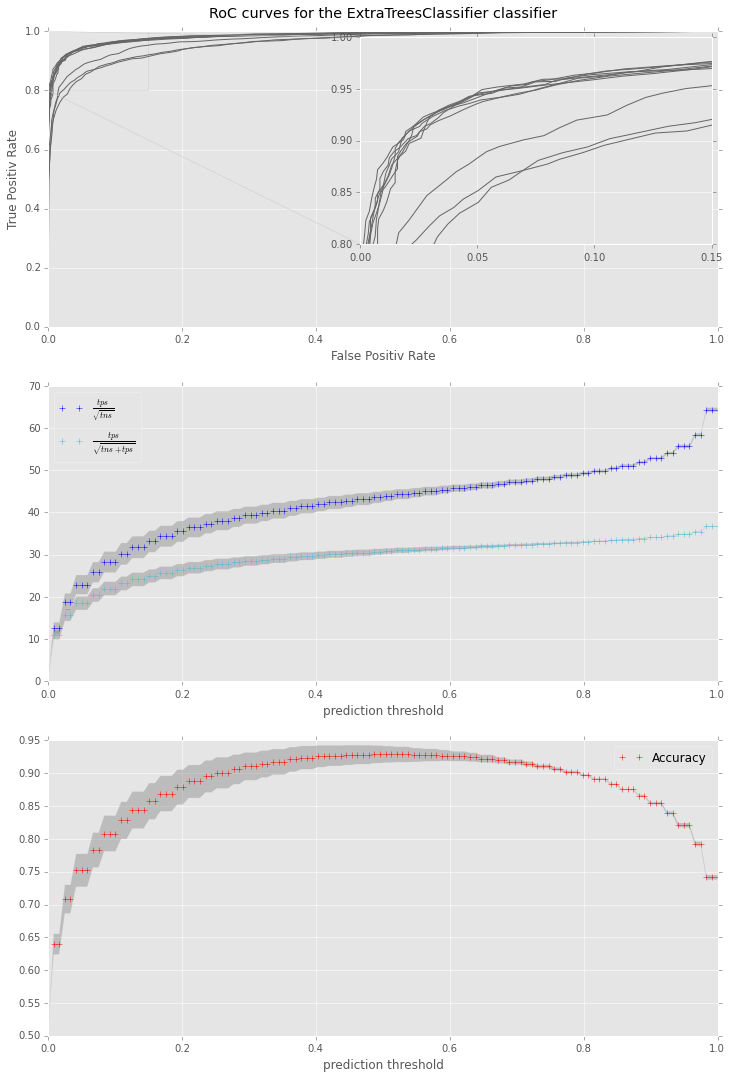

In [688]:
fs_extra_rf = ensemble.ExtraTreesClassifier(n_jobs=24, n_estimators=2*24, criterion="entropy")
fs_erf_aucs = classifier_crossval_perormance(X_sel, y.values, classifier=fs_extra_rf, bins=120)

In [689]:
print("Compare GNB to Features Slected GNB")
welch_test(fs_erf_aucs, erf_aucs)

Compare GNB to Features Slected GNB
[ 0.96271275  0.96201713  0.972843    0.9855125   0.98569875  0.98551075
  0.9838815   0.98492112  0.98661263  0.98507175]
[ 0.9857265   0.98456275  0.9896365   0.99607563  0.99652838  0.99566838
  0.99447038  0.99474225  0.9968435   0.995311  ]
Null hypothesis rejected with p: 0.0018149492978352427. ROC AUC differs significantly
